In [5]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import fnmatch
from linfit import linfit
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column



#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap, error):
    
    '''
    Returns the equivalend duratio of a flare event,
    found within indices [start, stop],
    calculated as the area under the residual (flux_gap-flux_model)
    Returns also the error on ED following (Davenport 2016)
    
    Parameters:
    --------------
    start - start time index of a flare event
    stop - end time index of a flare event
    time - time array
    flux_model - model quiescent flux 
    flux_gap - long-term trend removed raw light curve
    error - rolling std error to raw flux
    
    Returns:
    --------------
    ed - equivalent duration in seconds
    ederr - uncertainty in seconds
    '''
    
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    error = np.asarray(error)[start:stop+1]
    residual = flux - model
    ed = trapz(residual/model,time*60.*60.*24.)
    #measure error on ED
    
    flare_chisq = chisq(flux, error, model)
    ederr = np.sqrt(ed**2 / (stop-start) / flare_chisq)
    return ed, ederr, flare_chisq

def chisq(data, error, model):
    '''
    Compute the normalized chi square statistic:
    chisq =  1 / N * SUM(i) ( (data(i) - model(i))/error(i) )^2
    '''
    return np.sum( ((data - model) / error)**2.0 ) / np.size(data)


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
#    myloc = loc + '_my_flares.txt'
#     try:
#         myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
#     except OSError:
#         myflares = []

    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    return appaflares, appaids

def write_flares(forf,cluster, test, EPIC, typ='flares'):
    
    '''
    Writes a data frame with flares or flux 
    for a certain light curve with EPIC ID from a cluster
    analysed during a certain test.
    
    Parameter:
    ------------
    
    Returns:
    ------------
    '''
    
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    if typ == 'flares':
        forf.to_csv('{}/{}_flares.csv'.format(loc,EPIC))
    elif typ == 'flux':
        forf.to_csv('{}/{}_flux.csv'.format(loc,EPIC))
    return 



def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed, ederr = ED(row['istart_no_sys_no_thruster'],
                       row['istop_no_sys_no_thruster'],
                       flux.time,flux.flux_model,flux.flux_gap)
        
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges


DM = lambda x: 5.*np.log10(float(x))-5. 

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if outliers.empty: outliers=[]
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    #color = ['red' if val in outliers else 'black'
    return color

def CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,
                      kind = 'scatter', 
                      color=color_outlier_red(specs.index.values,outliers),
                      s=list(specs['counts']*2.),
                      title = '{}'.format(cluster))
    plot.set_ylabel(cid1[0])
    plot.set_xlabel('{}-{}'.format(cid1[0],cid2[0]))
    plot.text(0.9*specs[color].max(), 1.1*ylim[1], r'5 flares', fontsize=11)
    plot.plot(0.87*specs[color].max(), 1.086*ylim[1], 'o', markersize=10,color='black')
    fig = plot.get_figure()
    plot
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}_counts.jpg'.format(cluster,color),dpi=300)
    return

def energy(oid_list, cluster, test, specs):
    clusterenergy, clusterenergy_err, clustered, clusterederr = [], [], [], []
    for oid in oid_list:
        flux, flares = import_flares(cluster, test, oid)
        L_quiet = specs['L_quiet'].loc[oid]
        L_quiet_err = specs['L_quiet_err'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        tmyed, tenergy, tenergy_err = [],[],[]
        for i,row in s_s.iterrows():
            ed, ederr, chi2 = ED(row['istart_no_sys_no_thruster'],
                           row['istop_no_sys_no_thruster'],
                           flux.time,flux.flux_model,flux.flux_gap, flux.error)
            energy_err = energyerr(ed, ederr, L_quiet, L_quiet_err)
            if (ed != 'nan') & (ed > 0):
                clusterenergy.append(ed*L_quiet)
                clusterenergy_err.append(energy_err)
                tenergy.append(ed*L_quiet)
                tenergy_err.append(energy_err)
                tmyed.append(ed)
                clustered.append(ed)
                clusterederr.append(ederr)
            else:
                clusterenergy.append(np.nan)
                clusterenergy_err.append(np.nan)
                tenergy.append(np.nan)
                tenergy_err.append(np.nan)
                tmyed.append(np.nan)
                clustered.append(np.nan)
                clusterederr.append(np.nan)
        flares['myed'] = tmyed
        flares['myenerg'] = tenergy
        flares['myenerg_err'] = tenergy_err
        filtered = fnmatch.filter(flares.columns.values, 'Unnamed:*')
        flares = flares.drop(filtered,axis=1)
        c = pd.DataFrame({'clusterenergy':clusterenergy,
                                        'clusterenergy_err':clusterenergy_err,
                                        'clustered':clustered,
                                        'clusterederr':clusterederr})
        c['rel_energ_err']=c.clusterenergy_err/c.clusterenergy
        write_flares(flares, cluster, test, oid, typ='flares')
        c.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}/clusterenergies.csv'.format(cluster,test))
    return c

def energyerr(ed, ederr, L_quiet, L_quiet_err):
    #np.sqrt((ed * L_quiet_err)**2 + (ederr * L_quiet)**2) 
    return (ed * L_quiet_err) + (ederr * L_quiet)

def FFD(oid, cluster, test, specs,color='red'):
    flux, flares = import_flares(cluster, test, oid)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))

def cum_hist_average(oid_list, cluster, test, specs):

    c = energy(oid_list, cluster, test, specs)
    c = c.dropna(how='any')
    c = c.sort_values(by='clusterenergy')
    #hist, edges=np.histogram(np.log10(c.clusterenergy), bins=bins)
    c2 = np.asarray(c.clusterenergy_err**2)
    #binmids=[(x+edges[i])/2. for i,x in enumerate(edges[1:])]
    hist = np.ones_like(c.clusterenergy)
    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    err = np.sqrt(np.flip(np.cumsum(np.flip(c2,axis=0)),axis=0))/hist
    df = pd.DataFrame({'hi':hist,
                       'energ':c.clusterenergy,
                       'err':err,
                       'hi_err':np.sqrt(hist)})
    return df

def FFD_average(specs, cluster, test, class_='K7', 
                Tmin=3000., Tmax=7000., color='red',
                subset='class'):
    if subset == 'class':
        select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values 
                                               for c in class_] 
                                                 for i in sublist])
        label = '{}, n={}'.format(tuple(class_),len(select))
    elif subset == 'temperature':
        select = np.asarray([i for i in specs[(specs['T']>=Tmin) & (specs['T']<=Tmax)].index.values])
        label = '{}K - {}K, n={}'.format(Tmin,Tmax,len(select))
    df = cum_hist_average(select, cluster, test, specs)
    df = df[df.energ > 2.e32]
    df = df.dropna(how='any')

    #No uncertainty in energy:
    hist, binmids, err, hi_err = np.asarray(df.hi), np.asarray(df.energ), np.asarray(df.err), np.asarray(df.hi_err)
    p,residuals, rank, singular_values, rcond= np.polyfit(x=np.log10(binmids),y=np.log10(hist),deg=1, full=True)
    print(p,residuals, rank, singular_values, rcond)
    
    #Take into account uncertainty in energy
    df2 = np.log10(df)
    df2 = df2.dropna(how='any') 
    df2.err = np.abs(df2.energ-df2.err)
    df2.hi_err = np.abs(df2.hi-df2.hi_err)
    df2.hi_err.iloc[-1] = df2.hi_err.iloc[-2]
    hist2, binmids2 = np.asarray(df2.hi), np.asarray(df2.energ)
    err2, hi_err2 = np.asarray(df2.err), np.asarray(df2.hi_err)
    p2, var = linfit(binmids2,hist2, err2, hi_err2)


    #Print results
    plt.plot(np.log10(binmids), 
         p2[0]*np.log10(np.asarray(binmids))+p2[1],
         color='cyan',
         #label='Orthogonal distance regression.'
            )
    plt.plot(np.log10(binmids), 
             p[0]*np.log10(np.asarray(binmids))+p[1],
             #label='Least square fit, no x-errors.',
             color='black')
    alpha = r'{:.2f}$\pm${:.2f}'.format(p2[0],var[0])
    plt.scatter(np.log10(binmids), np.log10(hist), 
#                  xerr=[np.log10(binmids)-np.log10(err),
#                        np.log10(binmids)-np.log10(err)],
#                  yerr=[np.log10(hist)-np.log10(hi_err),
#                        np.log10(hist)-np.log10(hi_err)],
#                  fmt='o',
                 label='{}, alpha={}'.format(label,alpha))

    return list(p2), list(var)


## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [6]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.100,136.]
               }

cluster = 'NGC_1647'
basics = cluster_dict[cluster]
test = 'run_01'
dm = DM(basics[4])
global dm
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    print('Go back to step 6.')
    
specs[['T','T_err','L_quiet','L_quiet_err']].sort_values(by='T').head()

['/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/NGC_1647_parameter.csv']


,T,T_err,L_quiet,L_quiet_err
EPIC,,,,
247166643,3410.0,126.622799,6.484489e+29,1.997846e+29
247131381,3500.0,70.945989,8.912156e+29,2.103680e+29
247159731,3500.0,70.945989,8.912156e+29,2.103680e+29
247135437,3700.0,76.376262,1.967146e+30,4.608452e+29
247158149,3800.0,85.440037,2.744186e+30,6.550460e+29


In [7]:
flarelist = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/NGC_1647/results/run_01/NGC_1647_run_01_flarelist.txt',
    delimiter='\t')
flarelist = flarelist[['Object ID ',' Number of Flares ']]
flarelist = flarelist.rename(index=str, columns= {'Object ID ':'EPIC',' Number of Flares ':'counts'})
flarelist = flarelist.set_index('EPIC')
specs = specs.join(flarelist, how='left')
print(specs.T_err.describe())


count     82.000000
mean     135.403075
std       57.357367
min       30.550505
25%       86.216781
50%      122.586069
75%      195.192213
max      210.000000
Name: T_err, dtype: float64


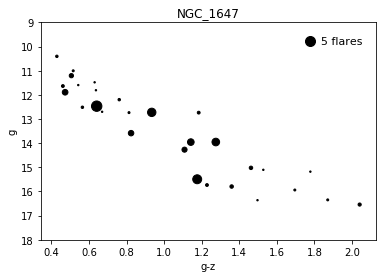

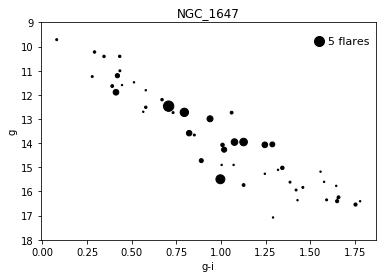

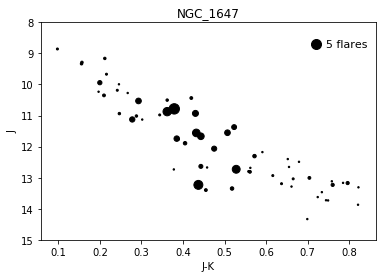

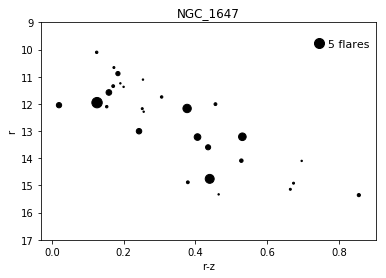

In [8]:
CMD_count(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(18,9))
CMD_count(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(18,9))
CMD_count(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(15,8))
CMD_count(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(17,9))

[-0.35225682 12.46755272] [0.02397624] 2 [1.41409505 0.01830783] 2.4424906541753444e-15
[-0.86568135 30.38376546] [0.85526651] 2 [1.41417662 0.01022252] 5.1958437552457326e-14
[-0.99594949 33.18979778] [0.05054613] 2 [1.4141984  0.00654891] 2.4424906541753444e-15


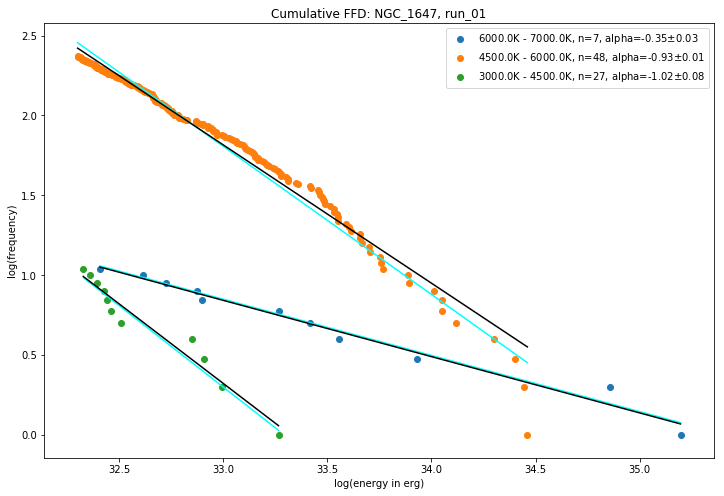

In [12]:
plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
trange = [(6e3,7e3,'green'),(4.5e3,6e3,'orange'),(3e3,4.5e3,'red')]
header = ['Tmin','Tmax','alpha','beta','alpha_err','beta_err']
results = pd.DataFrame(columns=header)
for (Tmin, Tmax, color) in trange:
    p, var = FFD_average(specs, cluster, test, color=color,
                     Tmin=Tmin,Tmax=Tmax,subset='temperature')
    l = [[i] for i in [Tmin,Tmax,p[0],p[1],var[0],var[1]]]
    t = pd.DataFrame(dict(list(zip(header,l))))
    results = results.append(t,ignore_index=True)
    plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')

plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.jpg'.format(cluster,test))
results.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/{0}_{1}_cum_FFD.csv'.format(cluster,test))